In [23]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from numba import njit, prange
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from IPython.display import display, HTML, Image
from scipy.interpolate import RegularGridInterpolator
import time
import pandas as pd
from copy import deepcopy
import seaborn as sns
from numba import set_num_threads
from itertools import product
from tqdm import tqdm
from collections import defaultdict
import copy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
})


In [24]:
# Cargar CSV correctamente
df = pd.read_csv(
    "caracterisation.csv",
    sep=";",        # separador correcto
    decimal=",",    # coma decimal
    engine="python"
)

# Verificación básica (recomendado)
print(df)
print(df.dtypes)


    pwm   max   min   avg
0  2000  13.4  12.0  12.4
1  1800  12.0  10.5  11.1
2  1600   9.4   8.1   8.8
3  1500   7.3   6.3   6.8
4  1400   5.5   4.8   5.2
5  1300   3.9   3.5   3.7
6  1200   2.4   2.1   2.3
pwm      int64
max    float64
min    float64
avg    float64
dtype: object


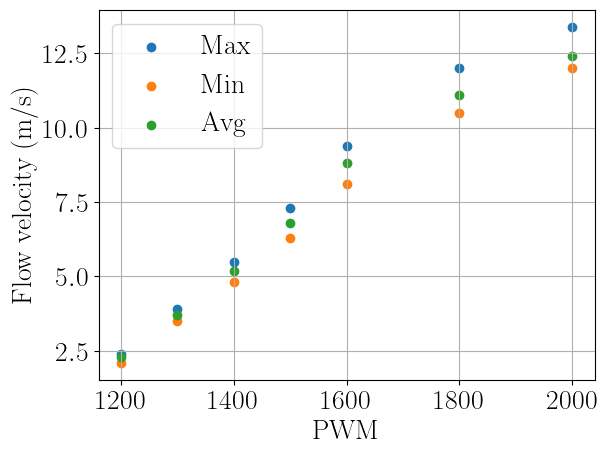

In [25]:
# Extraer datos
x = df["pwm"]
y_max = df["max"]
y_min = df["min"]
y_avg = df["avg"]

# Crear figura
plt.figure()

# Tres conjuntos scatter
plt.scatter(x, y_max, label="Max")
plt.scatter(x, y_min, label="Min")
plt.scatter(x, y_avg, label="Avg")

# Etiquetas
plt.xlabel("PWM")
plt.ylabel("Flow velocity (m/s)")
plt.legend()
plt.grid(True)

plt.show()


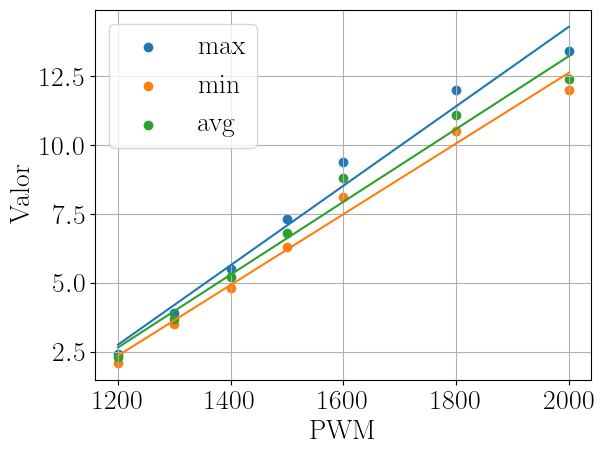

In [26]:
series = {
    "max": df["max"],
    "min": df["min"],
    "avg": df["avg"],
}

plt.figure()

for name, y in series.items():
    y = y.to_numpy()
    coef = np.polyfit(x, y, 1)
    y_fit = coef[0] * x + coef[1]

    plt.scatter(x, y, label=f"{name}")
    plt.plot(x, y_fit)

plt.xlabel("PWM")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()


## Inertial characterisation

In [64]:
rpm_data = {
    2000: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 4800.00, "pulses": 8},
        {"time": 0.300, "rpm": 7200.00, "pulses": 12},
        {"time": 0.400, "rpm": 7800.00, "pulses": 13},
        {"time": 0.500, "rpm": 7200.00, "pulses": 12},
        {"time": 0.600, "rpm": 7800.00, "pulses": 13},
        {"time": 0.700, "rpm": 7200.00, "pulses": 12},
        {"time": 0.800, "rpm": 7800.00, "pulses": 13},
        {"time": 0.900, "rpm": 6600.00, "pulses": 11},
        {"time": 1.000, "rpm": 5400.00, "pulses": 9},
        {"time": 1.100, "rpm": 2400.00, "pulses": 4},
        {"time": 1.200, "rpm": 1200.00, "pulses": 2},
        {"time": 1.300, "rpm": 2400.00, "pulses": 4},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1200.00, "pulses": 2},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 600.00, "pulses": 1},
        {"time": 2.300, "rpm": 600.00, "pulses": 1},
        {"time": 2.400, "rpm": 1200.00, "pulses": 2},
        {"time": 2.500, "rpm": 600.00, "pulses": 1},
        {"time": 2.600, "rpm": 600.00, "pulses": 1}
    ],
    
    1800: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 4800.00, "pulses": 8},
        {"time": 0.300, "rpm": 6600.00, "pulses": 11},
        {"time": 0.400, "rpm": 6600.00, "pulses": 11},
        {"time": 0.500, "rpm": 6600.00, "pulses": 11},
        {"time": 0.600, "rpm": 6000.00, "pulses": 10},
        {"time": 0.700, "rpm": 6600.00, "pulses": 11},
        {"time": 0.800, "rpm": 6600.00, "pulses": 11},
        {"time": 0.900, "rpm": 6600.00, "pulses": 11},
        {"time": 1.000, "rpm": 3600.00, "pulses": 6},
        {"time": 1.100, "rpm": 3000.00, "pulses": 5},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 2400.00, "pulses": 4},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 2400.00, "pulses": 4},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 1800.00, "pulses": 3},
        {"time": 2.000, "rpm": 1200.00, "pulses": 2},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 1800.00, "pulses": 3},
        {"time": 2.300, "rpm": 600.00, "pulses": 1},
        {"time": 2.400, "rpm": 600.00, "pulses": 1},
        {"time": 2.500, "rpm": 1200.00, "pulses": 2},
        {"time": 2.600, "rpm": 600.00, "pulses": 1},
        {"time": 2.700, "rpm": 600.00, "pulses": 1},
        {"time": 2.800, "rpm": 600.00, "pulses": 1},
        {"time": 2.900, "rpm": 600.00, "pulses": 1},
        {"time": 3.000, "rpm": 600.00, "pulses": 1},
        {"time": 3.100, "rpm": 600.00, "pulses": 1}
    ],
    
    1600: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 3000.00, "pulses": 5},
        {"time": 0.300, "rpm": 4800.00, "pulses": 8},
        {"time": 0.400, "rpm": 5400.00, "pulses": 9},
        {"time": 0.500, "rpm": 4800.00, "pulses": 8},
        {"time": 0.600, "rpm": 4800.00, "pulses": 8},
        {"time": 0.700, "rpm": 5400.00, "pulses": 9},
        {"time": 0.800, "rpm": 4800.00, "pulses": 8},
        {"time": 0.900, "rpm": 5400.00, "pulses": 9},
        {"time": 1.000, "rpm": 4200.00, "pulses": 7},
        {"time": 1.100, "rpm": 2400.00, "pulses": 4},
        {"time": 1.200, "rpm": 2400.00, "pulses": 4},
        {"time": 1.300, "rpm": 1800.00, "pulses": 3},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1800.00, "pulses": 3},
        {"time": 1.600, "rpm": 1200.00, "pulses": 2},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 1200.00, "pulses": 2},
        {"time": 2.000, "rpm": 1200.00, "pulses": 2},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 1200.00, "pulses": 2},
        {"time": 2.300, "rpm": 1200.00, "pulses": 2},
        {"time": 2.400, "rpm": 600.00, "pulses": 1},
        {"time": 2.500, "rpm": 600.00, "pulses": 1},
        {"time": 2.600, "rpm": 600.00, "pulses": 1},
        {"time": 2.700, "rpm": 600.00, "pulses": 1},
        {"time": 2.800, "rpm": 1200.00, "pulses": 2}
    ],
    
    1500: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 2400.00, "pulses": 4},
        {"time": 0.200, "rpm": 3600.00, "pulses": 6},
        {"time": 0.300, "rpm": 4800.00, "pulses": 8},
        {"time": 0.400, "rpm": 3600.00, "pulses": 6},
        {"time": 0.500, "rpm": 4200.00, "pulses": 7},
        {"time": 0.600, "rpm": 4199.83, "pulses": 7},
        {"time": 0.750, "rpm": 3600.10, "pulses": 9},
        {"time": 0.850, "rpm": 4200.00, "pulses": 7},
        {"time": 0.950, "rpm": 3000.00, "pulses": 5},
        {"time": 1.050, "rpm": 2400.00, "pulses": 4},
        {"time": 1.150, "rpm": 1800.00, "pulses": 3},
        {"time": 1.250, "rpm": 1800.00, "pulses": 3},
        {"time": 1.350, "rpm": 2400.00, "pulses": 4},
        {"time": 1.450, "rpm": 1200.00, "pulses": 2},
        {"time": 1.550, "rpm": 1200.00, "pulses": 2},
        {"time": 1.650, "rpm": 1200.00, "pulses": 2},
        {"time": 1.750, "rpm": 1800.00, "pulses": 3},
        {"time": 1.850, "rpm": 1800.00, "pulses": 3},
        {"time": 1.950, "rpm": 1200.00, "pulses": 2},
        {"time": 2.050, "rpm": 600.00, "pulses": 1},
        {"time": 2.150, "rpm": 1800.00, "pulses": 3},
        {"time": 2.250, "rpm": 600.00, "pulses": 1},
        {"time": 2.350, "rpm": 600.00, "pulses": 1}
    ],
    
    1400: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1200.00, "pulses": 2},
        {"time": 0.200, "rpm": 2400.00, "pulses": 4},
        {"time": 0.300, "rpm": 3000.00, "pulses": 5},
        {"time": 0.400, "rpm": 3000.00, "pulses": 5},
        {"time": 0.500, "rpm": 3000.00, "pulses": 5},
        {"time": 0.600, "rpm": 3000.00, "pulses": 5},
        {"time": 0.700, "rpm": 3000.00, "pulses": 5},
        {"time": 0.800, "rpm": 3600.00, "pulses": 6},
        {"time": 0.900, "rpm": 3000.00, "pulses": 5},
        {"time": 1.000, "rpm": 2400.00, "pulses": 4},
        {"time": 1.100, "rpm": 1800.00, "pulses": 3},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 1200.00, "pulses": 2},
        {"time": 1.400, "rpm": 1800.00, "pulses": 3},
        {"time": 1.500, "rpm": 1800.00, "pulses": 3},
        {"time": 1.600, "rpm": 1800.00, "pulses": 3},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1200.00, "pulses": 2},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 1200.00, "pulses": 2},
        {"time": 2.200, "rpm": 1200.00, "pulses": 2},
        {"time": 2.300, "rpm": 600.00, "pulses": 1}
    ],
    
    1300: [
        {"time": 0.000, "rpm": 600.00, "pulses": 1},
        {"time": 0.100, "rpm": 1800.00, "pulses": 3},
        {"time": 0.200, "rpm": 1800.00, "pulses": 3},
        {"time": 0.300, "rpm": 2400.00, "pulses": 4},
        {"time": 0.400, "rpm": 2400.00, "pulses": 4},
        {"time": 0.500, "rpm": 2400.00, "pulses": 4},
        {"time": 0.600, "rpm": 1800.00, "pulses": 3},
        {"time": 0.700, "rpm": 2400.00, "pulses": 4},
        {"time": 0.800, "rpm": 1800.00, "pulses": 3},
        {"time": 0.900, "rpm": 3000.00, "pulses": 5},
        {"time": 1.000, "rpm": 1800.00, "pulses": 3},
        {"time": 1.100, "rpm": 1200.00, "pulses": 2},
        {"time": 1.200, "rpm": 1800.00, "pulses": 3},
        {"time": 1.300, "rpm": 1200.00, "pulses": 2},
        {"time": 1.400, "rpm": 1200.00, "pulses": 2},
        {"time": 1.500, "rpm": 1200.00, "pulses": 2},
        {"time": 1.600, "rpm": 1800.00, "pulses": 3},
        {"time": 1.700, "rpm": 1200.00, "pulses": 2},
        {"time": 1.800, "rpm": 1800.00, "pulses": 3},
        {"time": 1.900, "rpm": 1200.00, "pulses": 2},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 600.00, "pulses": 1},
        {"time": 2.200, "rpm": 1200.00, "pulses": 2},
        {"time": 2.300, "rpm": 600.00, "pulses": 1},
        {"time": 2.400, "rpm": 1200.00, "pulses": 2}
    ],
    
    1200: [
        {"time": 0.000, "rpm": 1200.00, "pulses": 2},
        {"time": 0.100, "rpm": 600.00, "pulses": 1},
        {"time": 0.200, "rpm": 1200.00, "pulses": 2},
        {"time": 0.300, "rpm": 1200.00, "pulses": 2},
        {"time": 0.400, "rpm": 1200.00, "pulses": 2},
        {"time": 0.500, "rpm": 1200.00, "pulses": 2},
        {"time": 0.600, "rpm": 1200.00, "pulses": 2},
        {"time": 0.700, "rpm": 1200.00, "pulses": 2},
        {"time": 0.800, "rpm": 1200.00, "pulses": 2},
        {"time": 0.900, "rpm": 1200.00, "pulses": 2},
        {"time": 1.000, "rpm": 1800.00, "pulses": 3},
        {"time": 1.100, "rpm": 600.00, "pulses": 1},
        {"time": 1.200, "rpm": 1200.00, "pulses": 2},
        {"time": 1.300, "rpm": 600.00, "pulses": 1},
        {"time": 1.400, "rpm": 600.00, "pulses": 1},
        {"time": 1.500, "rpm": 600.00, "pulses": 1},
        {"time": 1.600, "rpm": 600.00, "pulses": 1},
        {"time": 1.700, "rpm": 600.00, "pulses": 1},
        {"time": 1.800, "rpm": 600.00, "pulses": 1},
        {"time": 1.900, "rpm": 600.00, "pulses": 1},
        {"time": 2.000, "rpm": 600.00, "pulses": 1},
        {"time": 2.100, "rpm": 600.00, "pulses": 1},
        {"time": 2.200, "rpm": 600.00, "pulses": 1}
    ]
}

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

PWMS = [1200, 1300, 1400, 1500, 1600, 1800, 2000]
T_CMD_END = 1.0  # el PWM dura hasta 1.0 s

# ----------------------------
# Construir DataFrame
# ----------------------------
rows = []
for pwm in PWMS:
    for r in rpm_data[pwm]:
        rows.append({
            "pwm": pwm,
            "time": float(r["time"]),
            "rpm": float(r["rpm"]),
        })
df = pd.DataFrame(rows).sort_values(["pwm", "time"]).reset_index(drop=True)


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

PWMS = [1200, 1300, 1400, 1500, 1600, 1800, 2000]
T_PEAK_MAX = 0.5
T_CMD_END = 1.0

# -------- df --------
rows = []
for pwm in PWMS:
    for r in rpm_data[pwm]:
        rows.append({"pwm": pwm, "time": float(r["time"]), "rpm": float(r["rpm"])})
df = pd.DataFrame(rows).sort_values(["pwm", "time"]).reset_index(drop=True)

# -------- helpers --------
def first_peak_before(t, y, t_max=0.5):
    mask = t <= t_max
    t2, y2 = t[mask], y[mask]
    idx = int(np.argmax(y2))
    return float(t2[idx]), float(y2[idx])

def crossing_time_first(t, y, target, direction="up"):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    cond = (y >= target) if direction == "up" else (y <= target)
    idxs = np.where(cond)[0]
    if len(idxs) == 0:
        return np.nan
    j = int(idxs[0])
    if j == 0:
        return float(t[0])
    t1, t2 = float(t[j-1]), float(t[j])
    y1, y2 = float(y[j-1]), float(y[j])
    if y2 == y1:
        return float(t2)
    a = (target - y1) / (y2 - y1)
    return float(t1 + a * (t2 - t1))

def time_to_zero_extrap(t, y):
    """Interpola si cruza 0; si no, extrapola lineal con los últimos 2 puntos si está bajando."""
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    # cruce real
    for i in range(len(y) - 1):
        if y[i] > 0 and y[i+1] <= 0:
            t1, t2 = t[i], t[i+1]
            y1, y2 = y[i], y[i+1]
            return float(t1 + (0 - y1) * (t2 - t1) / (y2 - y1))

    # extrap final
    if len(y) < 2:
        return np.nan
    t1, t2 = float(t[-2]), float(t[-1])
    y1, y2 = float(y[-2]), float(y[-1])
    if y2 >= y1:
        return np.nan
    m = (y2 - y1) / (t2 - t1)
    if m == 0:
        return np.nan
    return float(t2 + (0 - y2) / m)

def fit_tau_decay_from_1s(t, y, R_plateau):
    """
    Ajusta desde t>=1.0: y(t) ≈ R_plateau * exp(-(t-1)/tau).
    Si falla, devuelve nan.
    """
    if len(t) < 3:
        return np.nan

    # usa solo puntos positivos (evita log/ruido)
    mask = y > 0
    t, y = t[mask], y[mask]
    if len(t) < 3:
        return np.nan

    def resid(x):
        tau = max(float(x[0]), 1e-6)
        pred = R_plateau * np.exp(-(t - T_CMD_END) / tau)
        return pred - y

    try:
        res = least_squares(resid, x0=np.array([0.3]), bounds=(1e-6, 1000.0), loss="soft_l1", f_scale=200.0)
        return float(res.x[0]) if res.success else np.nan
    except Exception:
        return np.nan

def build_fit_for_pwm(g):
    t = g["time"].to_numpy(float)
    rpm = g["rpm"].to_numpy(float)

    # ordenar
    idx = np.argsort(t)
    t, rpm = t[idx], rpm[idx]

    t0 = float(t[0])
    rpm0 = float(rpm[0])

    # 1) primer máximo antes de 0.5 (solo para definir región estable)
    t_peak, _ = first_peak_before(t, rpm, t_max=T_PEAK_MAX)

    # 2) meseta = media desde t_peak hasta 1.0
    mask_plat = (t >= t_peak) & (t <= T_CMD_END)
    if np.any(mask_plat):
        R = float(np.mean(rpm[mask_plat]))
    else:
        # fallback: percentil alto antes de 1.0
        R = float(np.percentile(rpm[t <= T_CMD_END], 80))

    # 3) inicio real de meseta = primer cruce de R en subida (hasta 1.0)
    mask_rise = t <= T_CMD_END
    t_rise, rpm_rise = t[mask_rise], rpm[mask_rise]
    t_reach = crossing_time_first(t_rise, rpm_rise, R, direction="up")
    if not np.isfinite(t_reach):
        # fallback: usa t_peak
        t_reach = t_peak

    # 4) pendiente subida lineal hasta R
    slope = (R - rpm0) / max((t_reach - t0), 1e-9)

    # 5) desaceleración desde 1.0
    mask_decay = t >= T_CMD_END
    t_decay, rpm_decay = t[mask_decay], rpm[mask_decay]
    tau = fit_tau_decay_from_1s(t_decay, rpm_decay, R)

    # 6) tiempo hasta 0 (si no cruza, extrapola con cola real)
    t_zero = time_to_zero_extrap(t_decay, rpm_decay)

    # evaluator continuo (si tau nan -> usa cola lineal hasta t_zero)
    def eval_curve(tt):
        tt = np.asarray(tt, dtype=float)
        yy = np.zeros_like(tt)

        # tramo 1: lineal hasta t_reach
        m = slope
        b = rpm0 - m * t0
        mask1 = tt <= t_reach
        yy[mask1] = m * tt[mask1] + b

        # tramo 2: meseta hasta 1.0
        mask2 = (tt > t_reach) & (tt <= T_CMD_END)
        yy[mask2] = R

        # tramo 3: desde 1.0
        mask3 = tt > T_CMD_END
        if np.isfinite(tau):
            yy[mask3] = R * np.exp(-(tt[mask3] - T_CMD_END) / tau)
        else:
            # cola lineal a 0 usando t_zero (si existe)
            if np.isfinite(t_zero) and t_zero > T_CMD_END:
                yy[mask3] = np.clip(R * (1 - (tt[mask3] - T_CMD_END) / (t_zero - T_CMD_END)), 0, None)
            else:
                yy[mask3] = np.nan

        return np.maximum(yy, 0.0)

    return {
        "t0": t0, "rpm0": rpm0,
        "t_peak": t_peak,
        "t_reach": float(t_reach),
        "R": R,
        "slope": float(slope),
        "tau": float(tau) if np.isfinite(tau) else np.nan,
        "t_zero": float(t_zero) if np.isfinite(t_zero) else np.nan,
        "eval": eval_curve
    }

# ---- calcula fits ----
fits = {}
for pwm in PWMS:
    g = df[df["pwm"] == pwm].sort_values("time")
    fits[pwm] = build_fit_for_pwm(g)

# diagnóstico rápido (si ves nan aquí, ya sabes por qué “desaparece”)
diag = pd.DataFrame({
    "R": {p: fits[p]["R"] for p in PWMS},
    "tau": {p: fits[p]["tau"] for p in PWMS},
    "t_zero": {p: fits[p]["t_zero"] for p in PWMS},
    "t_reach": {p: fits[p]["t_reach"] for p in PWMS},
})
print(diag)


                R       tau  t_zero   t_reach
1200  1200.000000  1.133648     NaN  0.000000
1300  2250.000000  1.122147     NaN  0.275000
1400  3000.000000  0.809228     2.4  0.300000
1500  3942.847143  0.632784     NaN  0.228571
1600  4971.428571  0.557152     NaN  0.328571
1800  6150.000000  0.527329     NaN  0.275000
2000  7114.285714  0.298417     NaN  0.296429


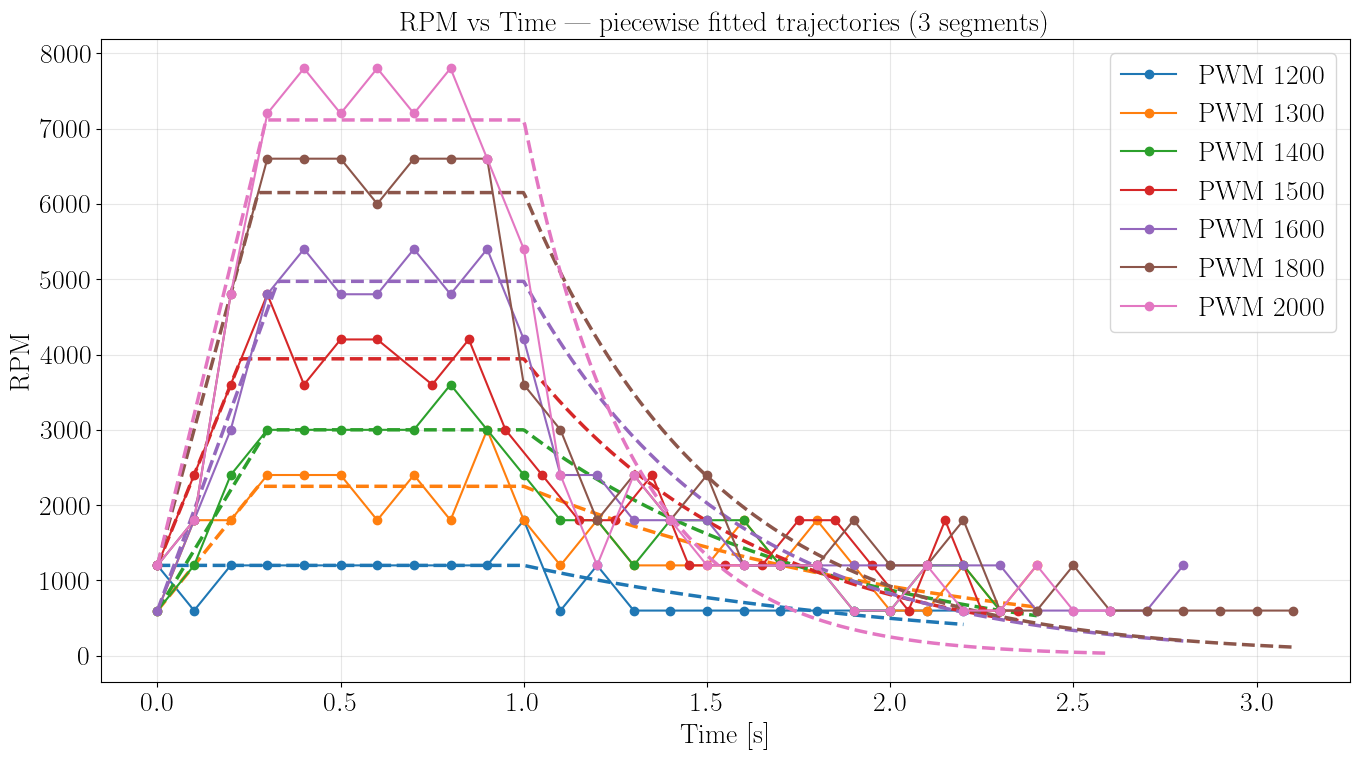

In [ ]:
plt.figure(figsize=(14, 8))

for pwm in PWMS:
    g = df[df["pwm"] == pwm].sort_values("time")
    t = g["time"].to_numpy(float)
    rpm = g["rpm"].to_numpy(float)

    # datos (capturo color)
    line = plt.plot(t, rpm, marker="o", linewidth=1.5, label=f"PWM {pwm}")[0]
    c = line.get_color()

    # curva ajustada
    f = fits[pwm]
    t_end = max(float(t.max()), float(f["t_zero"]) if np.isfinite(f["t_zero"]) else float(t.max()))
    tt = np.linspace(float(t.min()), t_end, 600)
    yy = f["eval"](tt)

    plt.plot(tt, yy, linestyle="--", linewidth=2.5, color=c)

plt.xlabel("Time [s]")
plt.ylabel("RPM")
plt.title("RPM vs Time — piecewise fitted trajectories (3 segments)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


       0%   60%   65%   70%   75%   80%   90%  100%
0%    0.0  0.00  0.28  0.30  0.23  0.33  0.28  0.30
60%   NaN  0.00  0.18  0.22  0.23  0.28  0.28  0.30
65%   NaN  0.71  0.00  0.09  0.14  0.20  0.22  0.24
70%   1.4  0.74  0.23  0.00  0.08  0.15  0.18  0.21
75%   NaN  0.75  0.35  0.17  0.00  0.08  0.12  0.16
80%   NaN  0.79  0.44  0.28  0.13  0.00  0.07  0.11
90%   NaN  0.86  0.53  0.38  0.23  0.11  0.00  0.05
100%  NaN  0.53  0.34  0.26  0.18  0.11  0.04  0.00


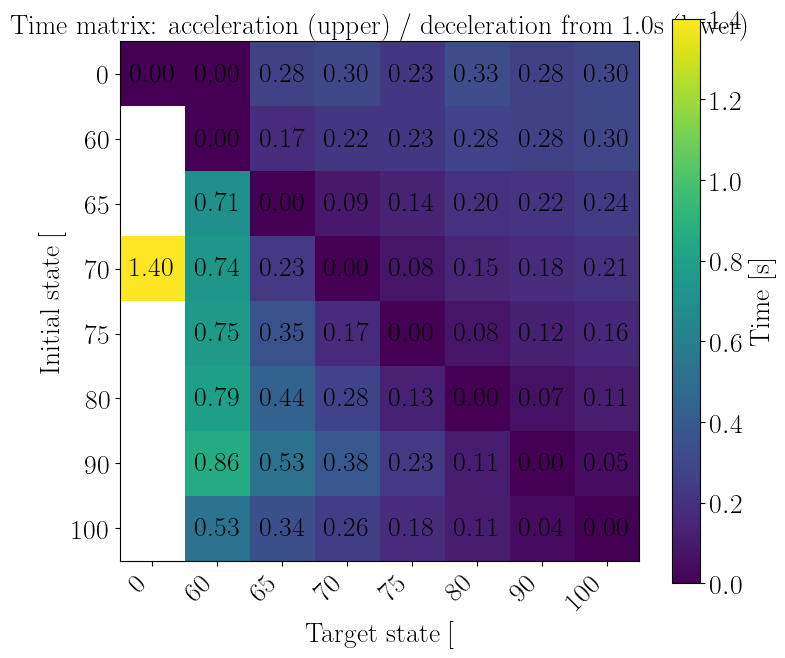

In [74]:
PWM_MAX = max(PWMS)

def pct_label(pwm):
    return f"{int(round(100*pwm/PWM_MAX))}%"

labels = ["0%"] + [pct_label(p) for p in PWMS]
label_to_pwm = {"0%": 0}
for p in PWMS:
    label_to_pwm[pct_label(p)] = p

# objetivos rpm (mesetas)
target_rpm = {0: 0.0}
for p in PWMS:
    target_rpm[p] = float(fits[p]["R"])

def t_up_in_high(high_pwm, rpm_target):
    """tiempo para alcanzar rpm_target en subida lineal del ensayo high_pwm."""
    f = fits[high_pwm]
    t0, rpm0, m = f["t0"], f["rpm0"], f["slope"]
    if rpm_target <= rpm0:
        return float(t0)
    if m <= 0:
        return np.nan
    t_hit = t0 + (rpm_target - rpm0) / m
    return float(min(t_hit, f["t_reach"]))  # clamp a fin de subida

def t_down_in_high_from_1(high_pwm, rpm_target):
    """tiempo absoluto para caer a rpm_target después de 1.0, usando exp si existe, si no lineal."""
    f = fits[high_pwm]
    R = f["R"]
    if rpm_target <= 0:
        # usa t_zero estimado con datos reales/extrap
        return f["t_zero"]

    if rpm_target >= R:
        return T_CMD_END

    tau = f["tau"]
    if np.isfinite(tau):
        return float(T_CMD_END + tau * np.log(R / rpm_target))

    # fallback lineal hasta 0 con t_zero
    t_zero = f["t_zero"]
    if np.isfinite(t_zero) and t_zero > T_CMD_END:
        # y(t) = R * (1 - (t-1)/(t_zero-1)) -> t = 1 + (1 - rpm/R)*(t_zero-1)
        return float(T_CMD_END + (1 - rpm_target / R) * (t_zero - T_CMD_END))

    return np.nan

# construir matriz
M = pd.DataFrame(np.nan, index=labels, columns=labels)
np.fill_diagonal(M.values, 0.0)

for i_lab in labels:
    for j_lab in labels:
        if i_lab == j_lab:
            continue

        i_pwm = label_to_pwm[i_lab]
        j_pwm = label_to_pwm[j_lab]

        i_idx = labels.index(i_lab)
        j_idx = labels.index(j_lab)

        # arriba diagonal: aceleración i->j usando ensayo j
        if i_idx < j_idx:
            high = j_pwm
            ti = t_up_in_high(high, target_rpm[i_pwm])
            tj = t_up_in_high(high, target_rpm[j_pwm])
            M.loc[i_lab, j_lab] = (tj - ti) if np.isfinite(ti) and np.isfinite(tj) else np.nan

        # abajo diagonal: desaceleración i->j usando ensayo i desde 1.0
        else:
            high = i_pwm
            t_hit = t_down_in_high_from_1(high, target_rpm[j_pwm])
            M.loc[i_lab, j_lab] = (t_hit - T_CMD_END) if np.isfinite(t_hit) else np.nan

M2 = M.round(2)
print(M2)

# plot
A = M.to_numpy(float)
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(A, aspect="equal")

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_title("Time matrix: acceleration (upper) / deceleration from 1.0s (lower)")
ax.set_xlabel("Target state [%]")
ax.set_ylabel("Initial state [%]")

for i in range(len(labels)):
    for j in range(len(labels)):
        if np.isfinite(A[i, j]):
            ax.text(j, i, f"{A[i, j]:.2f}", ha="center", va="center")

plt.colorbar(im, ax=ax, label="Time [s]")
plt.tight_layout()
plt.show()


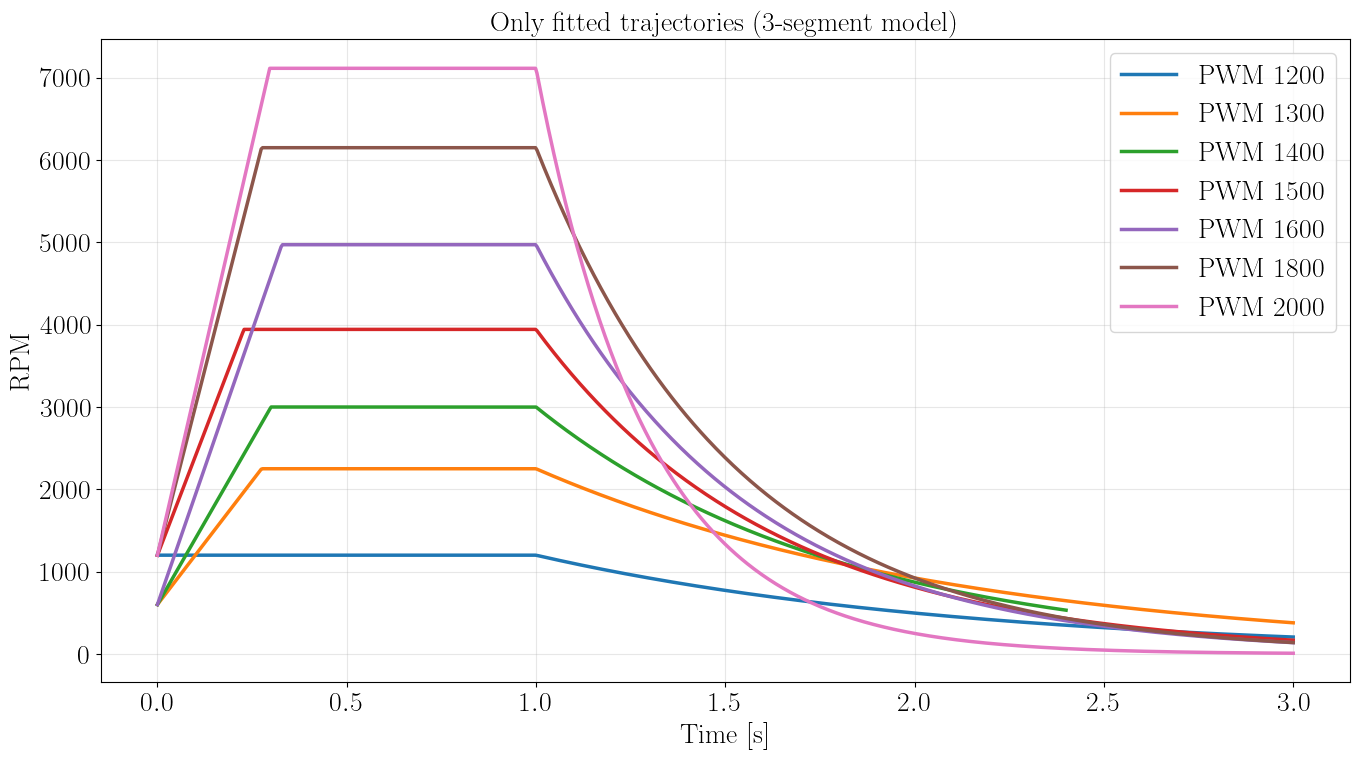

In [75]:
import numpy as np
import matplotlib.pyplot as plt

PWMS = [1200, 1300, 1400, 1500, 1600, 1800, 2000]

plt.figure(figsize=(14, 8))

for pwm in PWMS:
    f = fits[pwm]

    # Rango temporal: desde 0 hasta t_zero si existe, si no hasta 3.0
    t_end = f["t_zero"] if np.isfinite(f["t_zero"]) else 3.0
    tt = np.linspace(0.0, float(t_end), 800)
    yy = f["eval"](tt)

    plt.plot(tt, yy, linewidth=2.5, label=f"PWM {pwm}")

plt.xlabel("Time [s]")
plt.ylabel("RPM")
plt.title("Only fitted trajectories (3-segment model)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
import numpy as np
import pandas as pd

T_CMD_END = 1.0

def monotone_decreasing_envelope(y):
    y = np.asarray(y, dtype=float)
    env = np.copy(y)
    for k in range(1, len(env)):
        env[k] = min(env[k], env[k-1])
    return env

def crossing_time_first_down(t, y, target):
    """Primer cruce y<=target con interpolación lineal"""
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    idxs = np.where(y <= target)[0]
    if len(idxs) == 0:
        return np.nan
    j = int(idxs[0])
    if j == 0:
        return float(t[0])
    t1, t2 = float(t[j-1]), float(t[j])
    y1, y2 = float(y[j-1]), float(y[j])
    if y2 == y1:
        return float(t2)
    a = (target - y1) / (y2 - y1)
    return float(t1 + a * (t2 - t1))

def t_zero_from_env(t, y_env):
    """Tiempo donde env cruza 0 (o extrapola linealmente si no cruza)"""
    # cruce
    for i in range(len(y_env) - 1):
        if y_env[i] > 0 and y_env[i+1] <= 0:
            t1, t2 = t[i], t[i+1]
            y1, y2 = y_env[i], y_env[i+1]
            return float(t1 + (0 - y1) * (t2 - t1) / (y2 - y1))

    # extrap con los últimos 2 puntos (ahora sí debería estar bajando o igual)
    if len(y_env) < 2:
        return np.nan
    t1, t2 = float(t[-2]), float(t[-1])
    y1, y2 = float(y_env[-2]), float(y_env[-1])
    if y2 >= y1:
        # si está plana al final, no hay forma de extrapolar a 0
        return np.nan
    m = (y2 - y1) / (t2 - t1)
    return float(t2 + (0 - y2) / m)

# --- construir targets rpm desde mesetas ---
target_rpm = {0: 0.0}
for p in PWMS:
    target_rpm[p] = float(fits[p]["R"])  # meseta

# --- labels %
PWM_MAX = max(PWMS)
labels = ["0%"] + [f"{int(round(100*p/PWM_MAX))}%" for p in PWMS]
label_to_pwm = {"0%": 0}
for p in PWMS:
    label_to_pwm[f"{int(round(100*p/PWM_MAX))}%"] = p

# --- matriz nueva solo desaceleración (abajo diagonal) ---
M_dec = pd.DataFrame(np.nan, index=labels, columns=labels)
np.fill_diagonal(M_dec.values, 0.0)

for i_lab in labels:
    for j_lab in labels:
        i_idx = labels.index(i_lab)
        j_idx = labels.index(j_lab)
        if i_idx <= j_idx:
            continue  # solo abajo diagonal

        i_pwm = label_to_pwm[i_lab]
        j_pwm = label_to_pwm[j_lab]

        # ensayo del estado inicial (alto)
        g = df[(df["pwm"] == i_pwm) & (df["time"] >= T_CMD_END)].sort_values("time")
        t = g["time"].to_numpy(float)
        y = g["rpm"].to_numpy(float)

        if len(t) < 2:
            continue

        y_env = monotone_decreasing_envelope(y)

        # objetivo: rpm del estado j, pero no puede ser > meseta del i
        R_i = target_rpm[i_pwm]
        R_j = target_rpm[j_pwm]
        if j_pwm != 0:
            R_j = min(R_j, R_i)

        if j_pwm == 0:
            t_hit = t_zero_from_env(t, y_env)
        else:
            t_hit = crossing_time_first_down(t, y_env, R_j)

        if np.isfinite(t_hit):
            M_dec.loc[i_lab, j_lab] = float(t_hit - T_CMD_END)

print(M_dec.round(2))


       0%   60%   65%   70%   75%   80%  90%  100%
0%    0.0   NaN   NaN   NaN   NaN   NaN  NaN   NaN
60%   NaN  0.00   NaN   NaN   NaN   NaN  NaN   NaN
65%   NaN  0.10  0.00   NaN   NaN   NaN  NaN   NaN
70%   NaN  0.30  0.02  0.00   NaN   NaN  NaN   NaN
75%   NaN  0.45  0.07  0.05  0.00   NaN  NaN   NaN
80%   NaN  0.60  0.23  0.07  0.01  0.00  NaN   NaN
90%   NaN  0.60  0.16  0.10  0.00  0.00  0.0   NaN
100%  NaN  0.20  0.11  0.08  0.05  0.01  0.0   0.0


        0%   60%   65%   70%   75%   80%   90%  100%
0%    0.00  0.00  0.28  0.30  0.23  0.33  0.28  0.30
60%   8.04  0.00  0.18  0.22  0.23  0.28  0.28  0.30
65%   8.66  0.71  0.00  0.09  0.14  0.20  0.22  0.24
70%   6.48  0.74  0.23  0.00  0.08  0.15  0.18  0.21
75%   5.24  0.75  0.35  0.17  0.00  0.08  0.12  0.16
80%   4.74  0.79  0.44  0.28  0.13  0.00  0.07  0.11
90%   4.60  0.86  0.53  0.38  0.23  0.11  0.00  0.05
100%  2.65  0.53  0.34  0.26  0.18  0.11  0.04  0.00


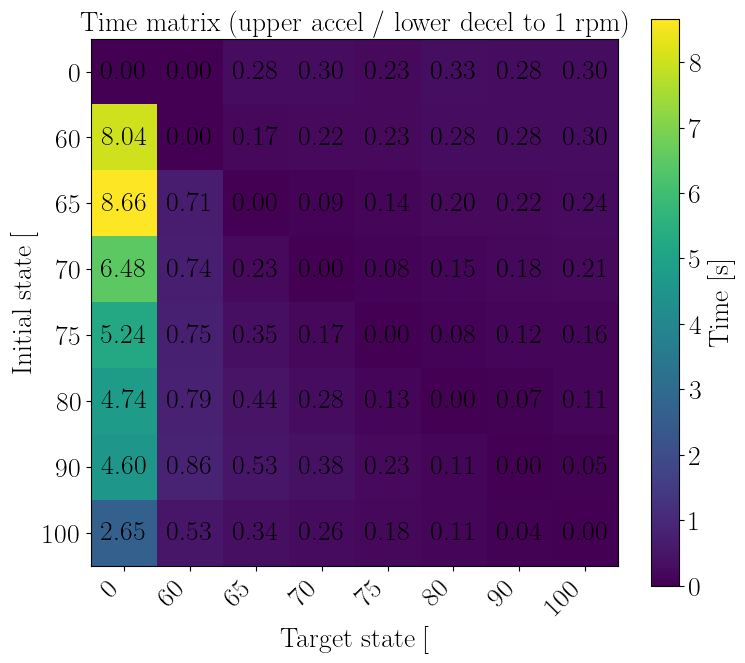

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PWMS = [1200, 1300, 1400, 1500, 1600, 1800, 2000]
PWM_MAX = max(PWMS)

T_CMD_END = 1.0
EPS_RPM = 1.0  # <-- define aquí tu “0 práctico” (1 rpm, 0.1 rpm, 10 rpm...)

def pct_label(pwm):
    return f"{int(round(100*pwm/PWM_MAX))}%"

labels = ["0%"] + [pct_label(p) for p in PWMS]
label_to_pwm = {"0%": 0}
for p in PWMS:
    label_to_pwm[pct_label(p)] = p

# Objetivos: meseta (media) por PWM (esto viene de tu fit)
target_rpm = {0: 0.0}
for p in PWMS:
    target_rpm[p] = float(fits[p]["R"])  # meseta

def t_up_in_high(high_pwm, rpm_target):
    """Tiempo absoluto para alcanzar rpm_target en subida lineal del ensayo high_pwm."""
    f = fits[high_pwm]
    t0, rpm0, m, t_reach = f["t0"], f["rpm0"], f["slope"], f["t_reach"]

    if rpm_target <= rpm0:
        return float(t0)
    if m <= 0:
        return np.nan

    t_hit = t0 + (rpm_target - rpm0) / m
    return float(min(max(t_hit, t0), t_reach))

def t_down_in_high_to_target(high_pwm, rpm_target):
    """
    Tiempo absoluto para caer a rpm_target desde t=1.0 usando la curva ajustada:
    y(t) = R * exp(-(t-1)/tau)
    """
    f = fits[high_pwm]
    R, tau = f["R"], f["tau"]

    if rpm_target <= 0:
        rpm_target = EPS_RPM  # “0” -> EPS para tiempo finito

    # objetivo no puede ser mayor que el valor inicial de la caída
    rpm_target = min(rpm_target, R)

    if not np.isfinite(tau) or tau <= 0:
        return np.nan

    if rpm_target == R:
        return float(T_CMD_END)

    return float(T_CMD_END + tau * np.log(R / rpm_target))

# -------- matriz completa --------
M = pd.DataFrame(np.nan, index=labels, columns=labels)
np.fill_diagonal(M.values, 0.0)

for i_lab in labels:
    for j_lab in labels:
        if i_lab == j_lab:
            continue

        i_pwm = label_to_pwm[i_lab]
        j_pwm = label_to_pwm[j_lab]
        i_idx = labels.index(i_lab)
        j_idx = labels.index(j_lab)

        # arriba diagonal: aceleración usando ensayo del target (j)
        if i_idx < j_idx:
            high = j_pwm
            ti = t_up_in_high(high, target_rpm[i_pwm])
            tj = t_up_in_high(high, target_rpm[j_pwm])
            M.loc[i_lab, j_lab] = (tj - ti) if np.isfinite(ti) and np.isfinite(tj) else np.nan

        # abajo diagonal: desaceleración usando ensayo del estado inicial (i), desde 1.0
        else:
            high = i_pwm
            t_hit = t_down_in_high_to_target(high, target_rpm[j_pwm])
            M.loc[i_lab, j_lab] = (t_hit - T_CMD_END) if np.isfinite(t_hit) else np.nan

M2 = M.round(2)
print(M2)

# -------- plot --------
A = M.to_numpy(float)
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(A, aspect="equal")

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_title(f"Time matrix (upper accel / lower decel to {EPS_RPM:g} rpm)")
ax.set_xlabel("Target state [%]")
ax.set_ylabel("Initial state [%]")

for i in range(len(labels)):
    for j in range(len(labels)):
        if np.isfinite(A[i, j]):
            ax.text(j, i, f"{A[i, j]:.2f}", ha="center", va="center")

plt.colorbar(im, ax=ax, label="Time [s]")
plt.tight_layout()
plt.show()
